In [1]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

conv_kerr_size = (3, 3)
maxpool_kerr_size = (2, 2)
model = Sequential()
model.add(Conv2D(32, conv_kerr_size, activation='relu', input_shape=(96, 96, 1)))
model.add(MaxPooling2D(maxpool_kerr_size))
model.add(BatchNormalization())

model.add(Conv2D(64, conv_kerr_size, activation='relu'))
model.add(MaxPooling2D(maxpool_kerr_size))
model.add(BatchNormalization())

model.add(Conv2D(128, conv_kerr_size, activation='relu'))
model.add(MaxPooling2D(maxpool_kerr_size))
model.add(BatchNormalization())

model.add(Conv2D(256, conv_kerr_size, activation='relu'))
# model.add(MaxPooling2D(maxpool_kerr_size))
# model.add(BatchNormalization())

model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 47, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       7

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

img_size = (96, 96)
img_stat_gen = ImageDataGenerator()
train_stat_gen = img_stat_gen.flow_from_directory('../data/stretched/train', target_size=img_size,
                                                  batch_size=1, color_mode='grayscale')

all_imgs = np.zeros((28709,) + img_size + (1,)).astype('uint16')
for i, (stat_imgs, _) in enumerate(train_stat_gen):
    img = stat_imgs[0].astype('uint8')
    all_imgs[i] = img
    if i >= 28709 - 1:
        break
    if i % 100 == 0:
        print(f'Step: {i}', end='\r')

Found 28709 images belonging to 7 classes.


In [3]:
img_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                                 zoom_range=0.1, shear_range=0.1, rotation_range=5, horizontal_flip=True,
                                 width_shift_range=0.1)
img_batch_size = 128
img_datagen.fit(all_imgs)
train_generator = img_datagen.flow_from_directory('../data/stretched/train',
                                                  target_size=img_size, batch_size=img_batch_size,
                                                  color_mode='grayscale', class_mode='categorical')
validation_generator = img_datagen.flow_from_directory('../data/stretched/val/',
                                                   target_size=img_size, batch_size=img_batch_size,
                                                   color_mode='grayscale', class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [4]:
import keras.callbacks as clb
callbacks = [
    clb.ReduceLROnPlateau(monitor='val_acc', factor=0.5, min_lr=1e-7, patience=2, verbose=1),
    clb.EarlyStopping(monitor='val_acc', patience=6, verbose=1),
    clb.ModelCheckpoint(monitor='val_acc', filepath='../models/augumented_model.h5',
                        save_best_only=True, verbose=1)
]
nr_of_train_pictures = 28709
train_steps = nr_of_train_pictures // img_batch_size + 1
nr_of_valid_pictures = 3589
valid_steps = nr_of_valid_pictures // img_batch_size + 1
history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=100,
                    validation_data=validation_generator, validation_steps=valid_steps, callbacks=callbacks,
                    verbose=2
                    )

Epoch 1/100
225/225 - 45s - loss: 1.7234 - acc: 0.3353 - val_loss: 1.7963 - val_acc: 0.2881

Epoch 00001: val_acc improved from -inf to 0.28810, saving model to ../models/../models/augumented_model.h5
Epoch 2/100
225/225 - 40s - loss: 1.4407 - acc: 0.4433 - val_loss: 1.5335 - val_acc: 0.4182

Epoch 00002: val_acc improved from 0.28810 to 0.41822, saving model to ../models/../models/augumented_model.h5
Epoch 3/100
225/225 - 40s - loss: 1.3247 - acc: 0.4927 - val_loss: 1.3061 - val_acc: 0.5026

Epoch 00003: val_acc improved from 0.41822 to 0.50265, saving model to ../models/../models/augumented_model.h5
Epoch 4/100
225/225 - 40s - loss: 1.2458 - acc: 0.5221 - val_loss: 1.3277 - val_acc: 0.5093

Epoch 00004: val_acc improved from 0.50265 to 0.50933, saving model to ../models/../models/augumented_model.h5
Epoch 5/100
225/225 - 40s - loss: 1.1890 - acc: 0.5479 - val_loss: 1.1712 - val_acc: 0.5503

Epoch 00005: val_acc improved from 0.50933 to 0.55029, saving model to ../models/../models/aug

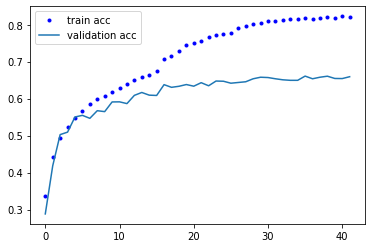

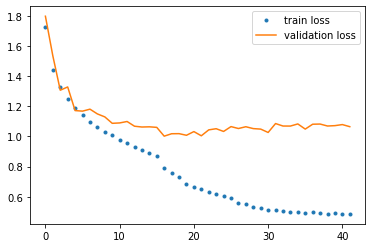

In [5]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='train acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '.', label='train loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()

plt.show()
